In [1]:
import torch
import matplotlib.pyplot as plt
from torchmetrics import JaccardIndex
from matplotlib import animation
from IPython.display import HTML



/home/dqian/miniconda3/envs/NYU-DL/lib/python3.10/site-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: '/home/dqian/miniconda3/envs/NYU-DL/lib/python3.10/site-packages/torchvision/image.so: undefined symbol: _ZN5torch3jit17parseSchemaOrNameERKNSt7__cxx1112basic_stringIcSt11char_traitsIcESaIcEEE'If you don't plan on using image functionality from `torchvision.io`, you can ignore this warning. Otherwise, there might be something wrong with your environment. Did you have `libjpeg` or `libpng` installed before building `torchvision` from source?
  warn(


In [2]:
# Load our own modules
import sys

sys.path.append("../src")

from data import *

In [19]:
# This draws a random frame for some reason... not worth figuring it out imo.
def plot_video(frames, normalized=True):
    # undo norm and matplot lib wants rgb in last dim
    if (normalized):
        frames = [unnormalize(f).movedim(0, 2).clamp(0, 1) for f in frames]
    
    fig = plt.figure()
    ax = plt.axes()
    def drawframe(i):
        plt.axis('off')
        ax.imshow(frames[i], interpolation='none')
        
    anim = animation.FuncAnimation(fig, drawframe, frames=len(frames), interval=100)
    return HTML(anim.to_html5_video())

In [4]:
dataset = ValidationDataset("../Dataset_Student")
labeled = LabeledDataset("../Dataset_Student")
unlabeled = UnlabeledDataset("../Dataset_Student")

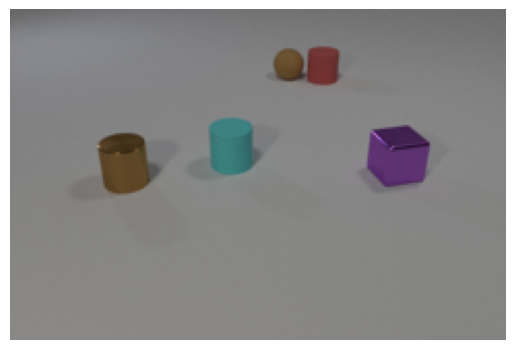

In [5]:
index = 600

frames, label = dataset[index]

plot_video(frames, normalized=True)

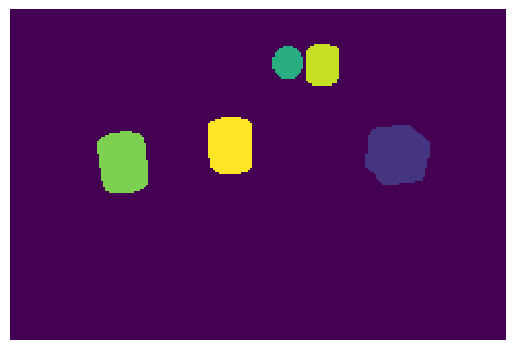

In [7]:
plt.axis("off")
plt.imshow(label[21], interpolation="none")
plt.savefig('label.png', bbox_inches=0, pad_inches = 0)

In [8]:
model = torch.load("../simvp.pth", map_location=torch.device('cpu'))

In [9]:

model.eval()
with torch.no_grad():
    # For end to end models
    # x = frames[:11].unsqueeze(0)#.transpose(1, 2)
    # output = model(x).transpose(1,2)

    x = frames[:11].unsqueeze(0)#.transpose(1, 2)
    output = model(x).transpose(1,2)

In [10]:
print(output.shape)
output = output.squeeze()
pred_frames = unnormalize(output.transpose(0, 1))
pred_frames.shape

torch.Size([1, 3, 11, 160, 240])


torch.Size([11, 3, 160, 240])

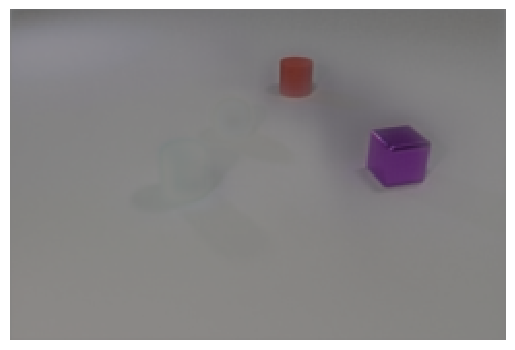

In [11]:
frame_index = 10
# mask = torch.argmax(output, dim=1).squeeze()
plt.axis("off")
# plt.imshow(mask[frame_index], interpolation="none")
plt.imshow(pred_frames[frame_index].movedim(0, -1), interpolation="none")

torch.Size([1, 11, 3, 160, 240])
torch.Size([11, 3, 160, 240])


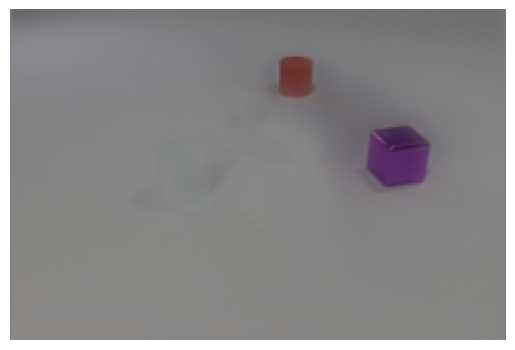

In [12]:
print(x.shape)
vid =  output.squeeze().transpose(0, 1)
print(vid.shape)
plot_video(torch.cat((x.squeeze(), vid)), normalized=True)

In [13]:
from unet.unet import *

model = torch.load("../best_model_unet_50_py.pth", map_location=torch.device('cpu'))

full_vid = torch.cat((x.squeeze(), vid))

print(full_vid.shape)

with torch.no_grad():
    outputs = []
    for i in range(22):
        x_unet = full_vid[i].unsqueeze(0)
        x_unet = torch.nn.functional.interpolate(x_unet, size=(256, 256), mode='bilinear', align_corners=False)
        output = model(x_unet)
        output = torch.nn.functional.interpolate(output, size=(160, 240), mode='bilinear', align_corners=False)
        outputs.append(output)
        print(f"Predicted mask for frame {i}")

    masks = torch.argmax(torch.cat(outputs), dim=1)

torch.Size([22, 3, 160, 240])
Predicted mask for frame 0
Predicted mask for frame 1
Predicted mask for frame 2
Predicted mask for frame 3
Predicted mask for frame 4
Predicted mask for frame 5
Predicted mask for frame 6
Predicted mask for frame 7
Predicted mask for frame 8
Predicted mask for frame 9
Predicted mask for frame 10
Predicted mask for frame 11
Predicted mask for frame 12
Predicted mask for frame 13
Predicted mask for frame 14
Predicted mask for frame 15
Predicted mask for frame 16
Predicted mask for frame 17
Predicted mask for frame 18
Predicted mask for frame 19
Predicted mask for frame 20
Predicted mask for frame 21


In [15]:
print(masks.shape)

torch.Size([22, 160, 240])


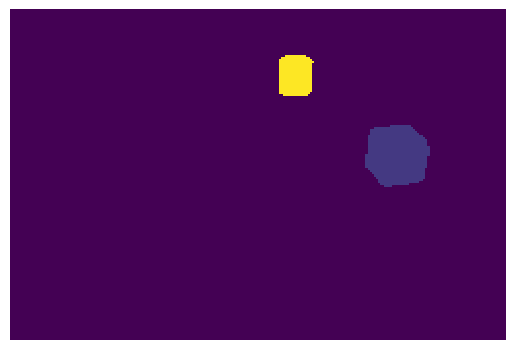

In [20]:
plot_video(masks, normalized=False)

In [ ]:
print(torch.unique(mask[frame]))
print(np.unique(label[11+frame]))

In [ ]:
iou = JaccardIndex(task="multiclass", num_classes=49)
iou_full = JaccardIndex(task="multiclass", num_classes=49, average="none")
print(iou(output, target))
print(iou_full(output,target))

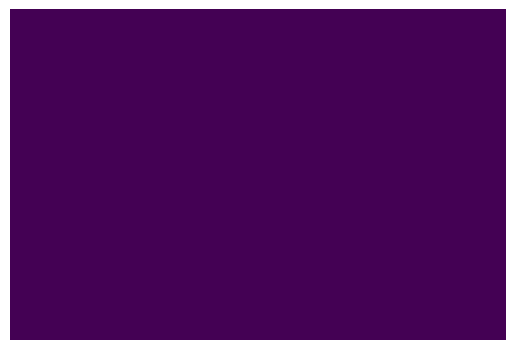

In [21]:
plt.axis("off")
plt.imshow(torch.zeros(160, 240))